# NRK todo:

1) Write function to calculate assembly activation in line with van de Ven and Trouche papers: Rk(t) = z(t)T*pk*z(t).  Make SURE to zero out diagnoal in pk!!!
  
2) Plot out assembly activation for Marble07 day 2.  

3) Compare to previous method, directly multiplying the ica weight * PSAbool.

4) Figure out why ICAs are so similar for this method - plot out zproj, PCmats (Zproj_cov), etc. and compare between Marble07 day 1 and 2.  Is it because ICA is not converging? Or for some other reason?

5) Play around with FastICA params: random_state, n_iters, tol, etc...

6) Tidy up parameters ued for running this method. Make dictionary for PCA, ICA, and Lopes dos Santos (call it dupret?).  should have both pca and ica params for dupret, e.g. `params['dupret']['pca']['whiten'] = False`, `params['dupret']['pca']['whiten'] = True`


In [1]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import pandas as pd

In [2]:
# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf
import freezing_analysis as fa
import helpers 
import eraser_reference as err

# Project save directory here
print_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'

First, run some sanity checks on your outputs - do you see blatant differences in outputs like covariance matrices for Marble07 day 1 (few freezing ensembles) vs day 2?  As a reminder, Day 2 has tons of freeze related ensembles whereas Day 1 has relative few.

In [3]:
DR1 = fa.DimReduction('Marble07', 'Shock', 1, ica_method='ica_on_cov')
DR2 = fa.DimReduction('Marble07', 'Shock', 2, ica_method='ica_on_cov')

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


calculating Dupret activations for plotting
calculating Dupret activations for plotting


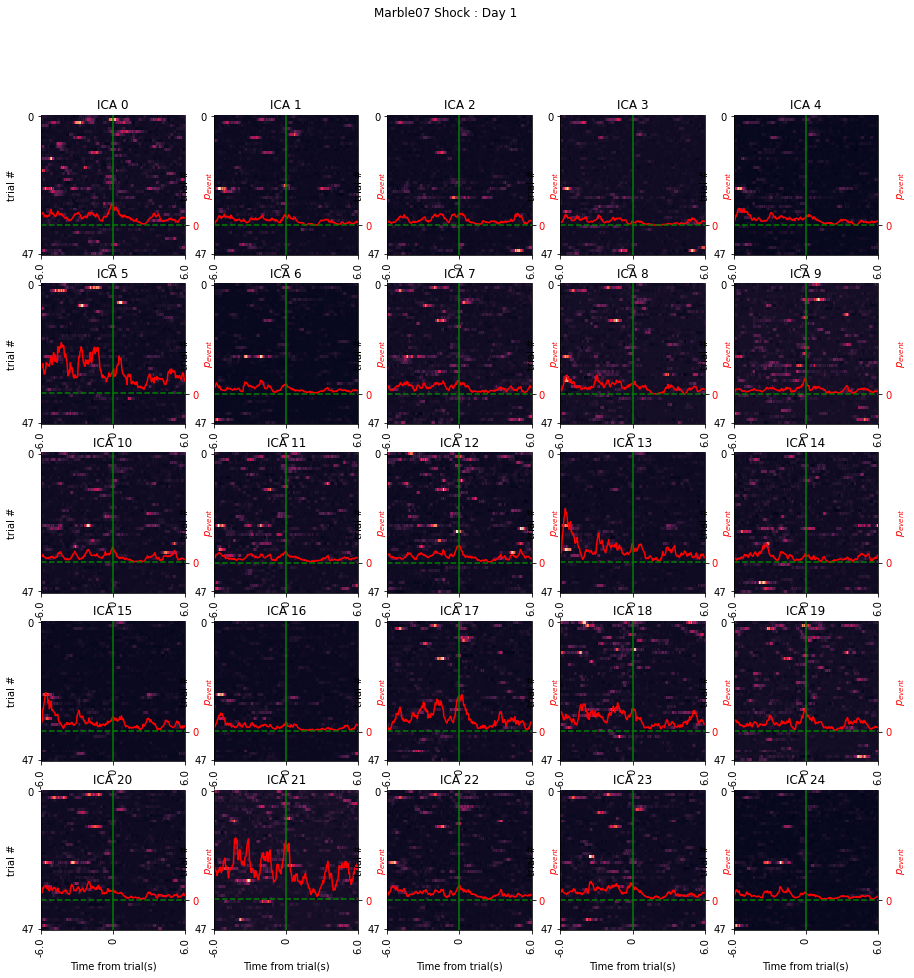

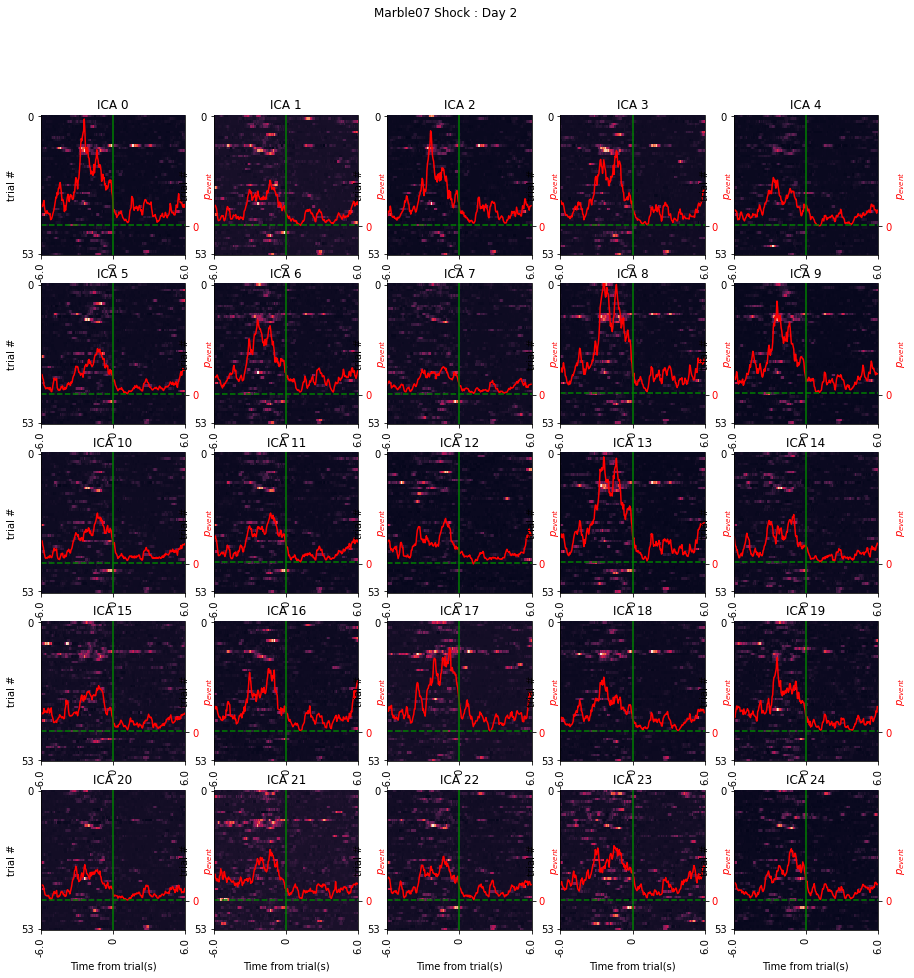

In [4]:
_ = DR1.plot_rasters(act_type='dupret', y2scale=3)
_ = DR2.plot_rasters(act_type='dupret', y2scale=3)

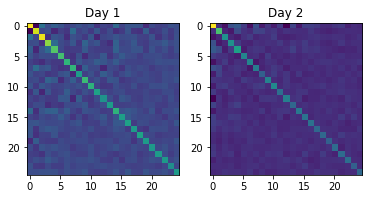

In [5]:
fig, ax = plt.subplots(1,2)
for a, DR in zip(ax, [DR1, DR2]):
    a.imshow(DR.cov_zproj)
    a.set_title('Day ' + str(DR.day))
    

Ok, super interesting.  Much less variability in PCs on day 2 than day 1, which might be why I'm getting such different results!  Check out distribution of weights - are they the same?  Also, try plotting the above with the diagonal zeroed out.  (Does the method have you do that???)

One possibility is that I am supposed to apply the ICA method to the Zproj matrix, not the `cov_zproj` as shown above.  Let's give that a shot.

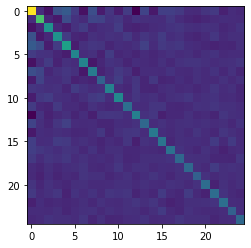

In [20]:
fig, ax = plt.subplots()
ax.imshow(np.cov(DR.zproj))

Text(0.5, 1.0, 'W mat: ICA onto cov(Zproj)')

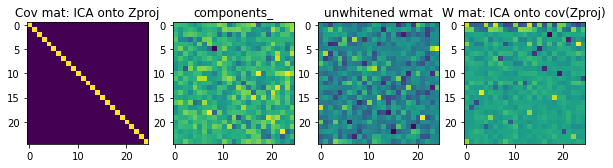

In [37]:
from sklearn.decomposition import FastICA, PCA
ICAtransformer = FastICA(whiten=True)
zica = ICAtransformer.fit_transform(DR.zproj.T).T
w = np.dot(ICAtransformer.components_, np.linalg.inv(ICAtransformer.whitening_))

fig, ax = plt.subplots(1,4)
fig.set_size_inches((10, 5))
ax[0].imshow(np.cov(zica))
ax[0].set_title('Cov mat: ICA onto Zproj')
ax[1].imshow(ICAtransformer.components_)
ax[1].set_title('components_')
ax[2].imshow(w)
ax[2].set_title('unwhitened wmat')
ax[3].imshow(DR.w_mat)
ax[3].set_title('W mat: ICA onto cov(Zproj)')

In [39]:
fig.get_size_inches()

array([6., 4.])

Ok, so the first method (not yet implemented) seems to be doing a much better job of separating things than the method I used.  This is MOST LIKELY because the original method used (ICA on PCA-projected covariance matrix) is NOT CORRECT.

However, this also hints that, on some days, we might be ending up with redundant freezing assemblies using the incorrect method because the PC(s) associated with freezing have much larger weights than others. So, it could be very interesting to assess and track the highest PC weight of the freeze-related ensemble across days...

For now, let's check our work re-running the above with the new method.

BIG QUESTION: Do I need to whiten the data while running ICA (whiten=True), or leave it alone (whiten=False).  I think True is correct since cov_zproj is not the identity matrix (although it is pretty close...).

In [22]:
DR1z = fa.DimReduction('Marble07', 'Shock', 1, ica_method='ica_on_zproj', whiten=True)
DR2z = fa.DimReduction('Marble07', 'Shock', 2, ica_method='ica_on_zproj', whiten=True)

calculating Dupret activations for plotting
calculating Dupret activations for plotting


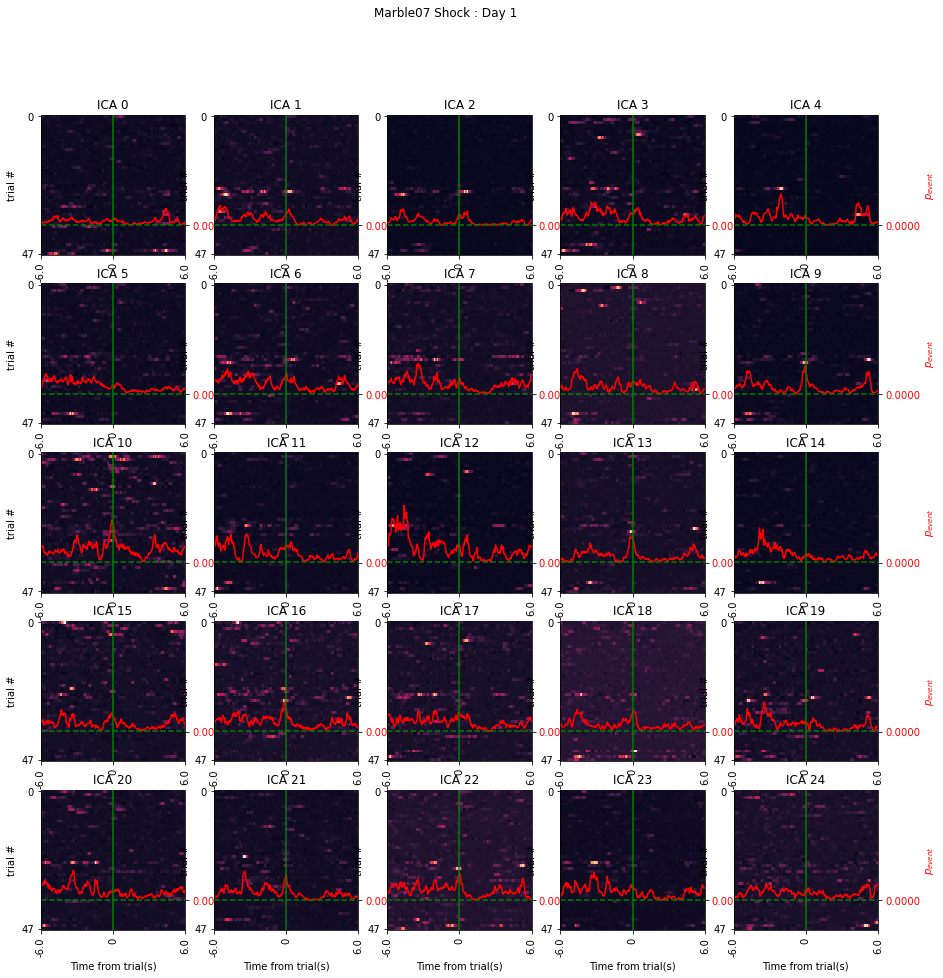

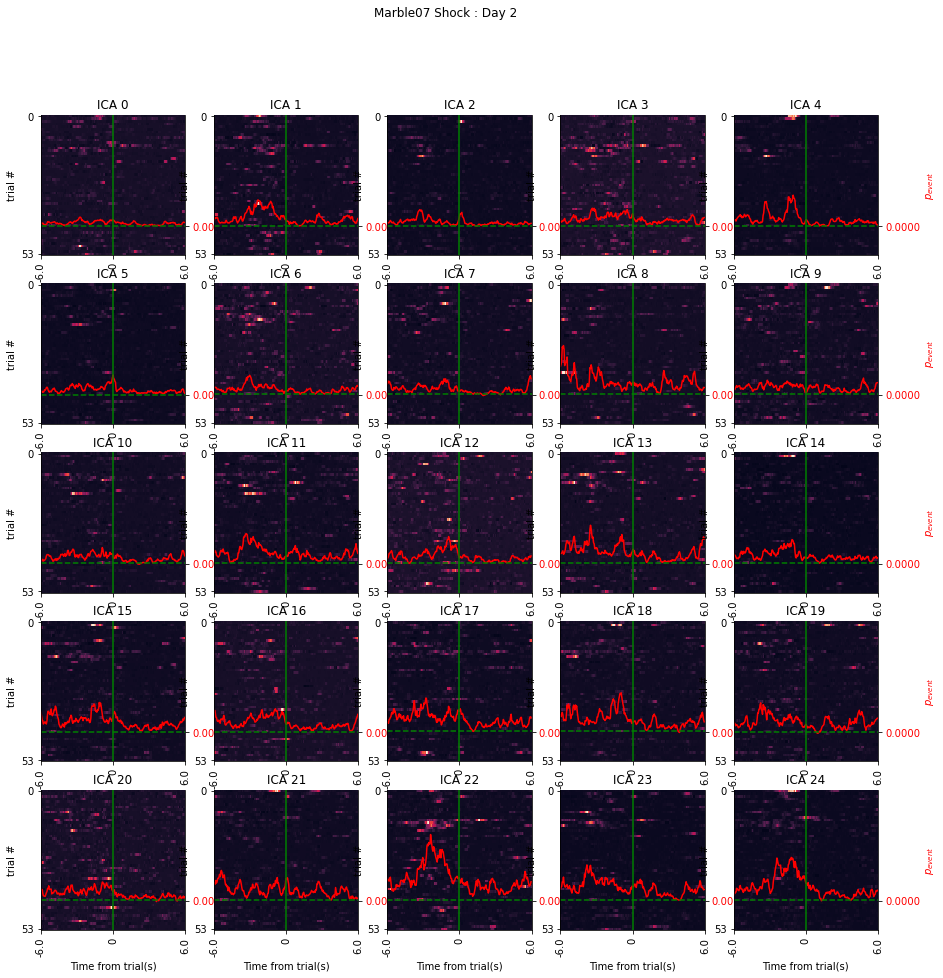

In [32]:
_ = DR1z.plot_rasters(act_type='dupret', y2scale=0.0001)
_ = DR2z.plot_rasters(act_type='dupret', y2scale=0.0001)

# NRK todo:

0) Do I need to separate unmixing and whitening matrix from the ICA output? I think so!!!

0.5) Scale v mat weights to have unit length!

1) Plot out activations over time to check if truly independent AND if related to freezing.

2) Assess statistics of assembly activations - are they significantly above chance around freezing? Use same shuffle method as for single cells. Any way to assess reliability, or is the shuffle test sufficient?

3) Clean up code! Initialize and save Dupret activations with psa type at the get-go, save to dictionary maybe so you can adjust later? Write function to check if they are already in dict and quickly plot if they aren't...